In [2]:
import sys 
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass 
from physics.fom import sensitivity, sfm, mcf, tsf 
from physics.reflectometry import _kz, reflectivity

from problems.base1 import Bounds, SOISpec, CapSpec, MRL, Materials, Base1OptimizationProblem, SubstrateSpec, MRL
from data.materials_loader import load_base1_materials

Sample $\theta \in \mathbb{R}^4$

In [4]:
# simple magnetic SLD model for now – tweak later if you want
def m_sld_from_x(x: float) -> float:
    return 1.0 * x  # placeholder linear scaling

materials = load_base1_materials("data.json", m_sld_from_x=m_sld_from_x)




In [5]:
from math import pi 

# Random test, will match with the paper when i get the data 
sois = [
    SOISpec("SOI1", rho_n=6.0, thickness=50.0, sigma=3.0),
    SOISpec("SOI2", rho_n=2.0, thickness=80.0, sigma=3.0),
]

Q = np.linspace(0.005, 0.3, 400)

bounds_x = Bounds(0.0, 1.0)      # x_coti
bounds_d = Bounds(20.0, 300.0)   # d_mrl
bounds_cap = Bounds(5.0, 200.0)    # d_cap

# define problem: 

problem = Base1OptimizationProblem(
    materials=materials,
    soi_list=sois,
    q_grid=Q,
    bounds_x=bounds_x,
    bounds_d=bounds_d,
    bounds_cap=bounds_cap,
)
problem

In [6]:
space = problem.search_space
print(f"Params name: {space.names}")
print(f"dimensions: {len(space)}")

theta_raw = space.sample(5)   # (5, 3)
theta = np.vstack([space.clip(row) for row in theta_raw])  # clip each row

print("Raw samples:\n", theta_raw)
print("Clipped samples:\n", theta)

x0 = space.unpack(theta[0])   # first sample as dict
x0



Params name: ['x_coti', 'd_mrl', 'd_cap', 'cap']
dimensions: 4
Raw samples:
 [[2.79502864e-01 2.87847531e+02 1.53610298e+02 0.00000000e+00]
 [3.74806669e-01 1.03989428e+02 5.28535300e+01 0.00000000e+00]
 [6.69637038e-01 2.23964983e+02 1.59663858e+02 0.00000000e+00]
 [8.02395648e-01 2.34066942e+02 1.54956610e+02 0.00000000e+00]
 [7.55903380e-01 9.11689156e+01 1.33668834e+02 1.00000000e+00]]
Clipped samples:
 [[2.79502864e-01 2.87847531e+02 1.53610298e+02 0.00000000e+00]
 [3.74806669e-01 1.03989428e+02 5.28535300e+01 0.00000000e+00]
 [6.69637038e-01 2.23964983e+02 1.59663858e+02 0.00000000e+00]
 [8.02395648e-01 2.34066942e+02 1.54956610e+02 0.00000000e+00]
 [7.55903380e-01 9.11689156e+01 1.33668834e+02 1.00000000e+00]]


{'x_coti': 0.2795028640557472,
 'd_mrl': 287.84753059083147,
 'd_cap': 153.61029761907545,
 'cap': 'Al2O3'}

In [7]:
# Eval obj 

y0 = problem.evaluate_objective(
    x_coti=x0["x_coti"],
    d_mrl=x0["d_mrl"],
    cap=x0["cap"],   
    d_cap=x0["d_cap"],
)
y0

0.39219831715811315

mateirals -> layers -> reflectivity -> fom -> TSF 

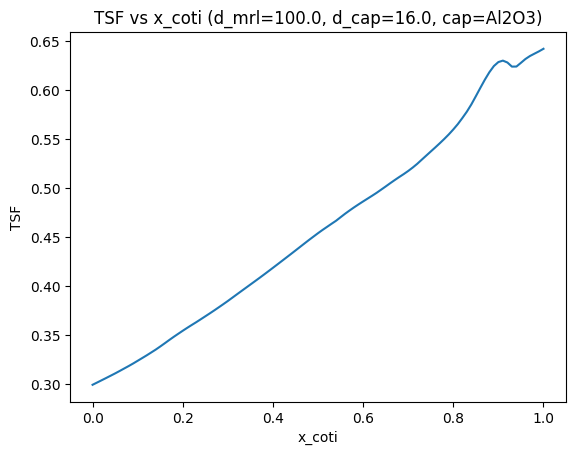

In [8]:
xs = np.linspace(bounds_x.lo, bounds_x.hi, 101)
ys = []

fixed_d_mrl = 100.0
fixed_d_cap = 16.0
fixed_cap = list(materials.caps.keys())[0]  # e.g. "Al2O3"

for x_coti in xs:
    ys.append(
        problem.evaluate_objective(
            x_coti=x_coti,
            d_mrl=fixed_d_mrl,
            cap=fixed_cap,
            d_cap=fixed_d_cap,
        )
    )

plt.plot(xs, ys)
plt.xlabel("x_coti")
plt.ylabel("TSF")
plt.title(f"TSF vs x_coti (d_mrl={fixed_d_mrl}, d_cap={fixed_d_cap}, cap={fixed_cap})")
plt.show()


## Small random search 


In [37]:
best_y = -np.inf 
best_x = None 


evals: int = 200

for i in range(evals): 
    theta = space.clip(space.sample(1)[0])
    x = space.unpack(theta)

    y = problem.evaluate_objective(
        x_coti=x["x_coti"],
        d_mrl=x["d_mrl"], 
        cap=x["cap"],
        d_cap=x["d_cap"],
    )

    if y > best_y: 
        best_y = y
        best_x = x


print(f"best y: {best_y}")
print("--------------")
print(f"best x: {best_x}")

best y: 1.0901774153213548
--------------
best x: {'x_coti': 0.8704340919255317, 'd_mrl': 88.07092568072166, 'd_cap': 190.51863960496462, 'cap': 'SiO2'}
